
<img style="float: right;" src="https://www.inderdhillon.com/files/logo-gray.png" alt="InderDhillon.com" height="120" width="120">

<h1>Opening An Establishment</h1><br>
<b>Inder Dhillon</b><br>
<i>inderdhillon.com</i><br>
Using clustering to find localities in Vancouver to suggest a business strategy for opening an establishment (in this case a pizza place) tailored to the locality.
<hr><br>
Importing required libraries:

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Reading dataset of localities in Vancouver from the website of City of Vancouver:

In [2]:
vancouver = pd.read_csv('https://opendata.vancouver.ca/explore/dataset/local-area-boundary/download/?format=csv&timezone=America/New_York&use_labels_for_header=true&csv_separator=%3B', delimiter=';')

In [3]:
# Splitting latitude and longitude values
lat_lng = vancouver['geo_point_2d'].str.split(',')
lat = []
lng = []
for value in lat_lng:
    lat.append(value[0])
    lng.append(value[1])
vancouver['Latitude'] = lat
vancouver['Longitude'] = lng
vancouver = vancouver.drop(['geo_point_2d'],axis=1)

In [4]:
vancouver.head()

,MAPID,Name,Geom,Latitude,Longitude
0,AR,Arbutus-Ridge,"{""type"": ""Polygon"", ""coordinates"": [[[-123.152...",49.2468049108,-123.161669238
1,CBD,Downtown,"{""type"": ""Polygon"", ""coordinates"": [[[-123.112...",49.2807470711,-123.116567008
2,FAIR,Fairview,"{""type"": ""Polygon"", ""coordinates"": [[[-123.145...",49.2645404871,-123.131048865
3,GW,Grandview-Woodland,"{""type"": ""Polygon"", ""coordinates"": [[[-123.077...",49.2764396102,-123.066728221
4,HS,Hastings-Sunrise,"{""type"": ""Polygon"", ""coordinates"": [[[-123.056...",49.277934053,-123.040269923


Visualizing the localities:

In [5]:
map_vancouver = folium.Map(location=[49.25, -123.1207], zoom_start=12)

# add markers to map
for geom in vancouver['Geom']:
    folium.GeoJson(
    geom).add_to(map_vancouver)
for lat, lng, name in zip(vancouver['Latitude'], vancouver['Longitude'], vancouver['Name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)


<img src='https://github.com/Inder-Dhillon/Where-To-Open-Establishment/raw/master/files/Vancouver.PNG' style="float: left;">

In [6]:
# The code was removed by Watson Studio for sharing.

#### Getting venues within said localities using Foursquare API and using a function to add them to a dataset:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            200)
                        
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

vancouver_venues = getNearbyVenues(names=vancouver['Name'],
                                   latitudes=vancouver['Latitude'],
                                   longitudes=vancouver['Longitude'])

In [8]:
vancouver_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus-Ridge,49.2468049108,-123.161669238,Tachia Bakery & Deli,49.249781,-123.167872,Bakery
1,Arbutus-Ridge,49.2468049108,-123.161669238,Arbutus Mall,49.248724,-123.154292,Shopping Mall
2,Arbutus-Ridge,49.2468049108,-123.161669238,Arbutus Village,49.248806,-123.154121,Shopping Mall
3,Arbutus-Ridge,49.2468049108,-123.161669238,Van Den Bosch Bakery,49.248936,-123.154130,Bakery
4,Downtown,49.2807470711,-123.116567008,L'Hermitage,49.280139,-123.117480,Hotel


Employing the onehot technique to get numerical data for K-Means clustering:

In [9]:
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = vancouver_venues['Neighborhood'] 
vancouver_onehot = vancouver_onehot.groupby('Neighborhood').mean().reset_index()

vancouver_onehot.head()

,Neighborhood,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Toy / Game Store,Trade School,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arbutus-Ridge,0.0,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.00,0.0,0.0,0.0
1,Downtown,0.0,0.0,0.01,0.00000,0.000000,0.010000,0.0,0.000000,0.0,...,0.020000,0.01,0.0,0.000000,0.0,0.02000,0.01,0.0,0.0,0.0
2,Dunbar-Southlands,0.0,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.000000,0.0,0.00000,0.00,0.0,0.0,0.0
3,Fairview,0.0,0.0,0.00,0.02381,0.047619,0.000000,0.0,0.047619,0.0,...,0.000000,0.00,0.0,0.000000,0.0,0.02381,0.00,0.0,0.0,0.0
4,Grandview-Woodland,0.0,0.0,0.00,0.00000,0.033898,0.016949,0.0,0.016949,0.0,...,0.016949,0.00,0.0,0.033898,0.0,0.00000,0.00,0.0,0.0,0.0


Finding the best k number of clusters to get optimal level of similarity within each cluster:

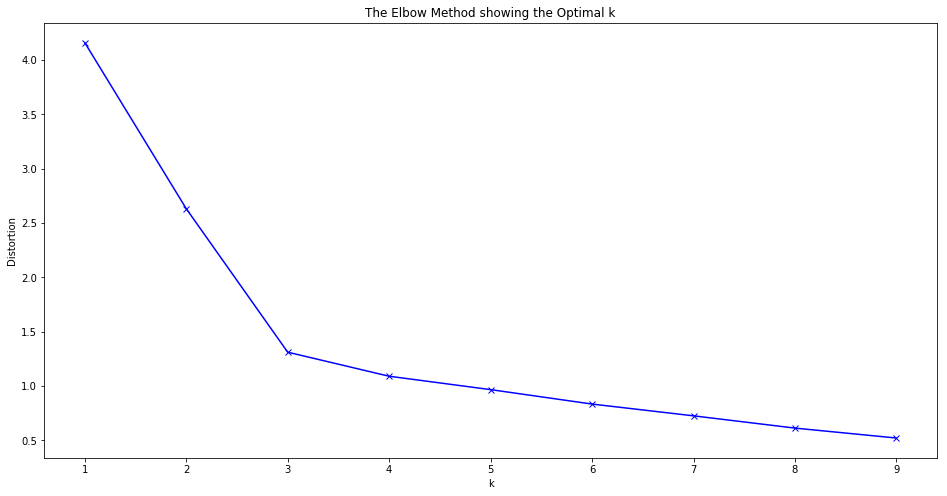

In [20]:
vancouver_cluster_data = vancouver_onehot.drop('Neighborhood', axis=1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(vancouver_cluster_data)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the Optimal k')
plt.show()

The elbow point is at 3 which is therefore the optimal k.
Deploying K-Means clustering using k=3:

In [11]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vancouver_cluster_data)
clustered_vancouver = vancouver_onehot
clustered_vancouver['Cluster'] = kmeans.labels_
vancouver = vancouver.merge(clustered_vancouver.loc[:,['Neighborhood','Cluster']], left_on='Name',right_on='Neighborhood')
vancouver

,MAPID,Name,Geom,Latitude,Longitude,Neighborhood,Cluster
0,AR,Arbutus-Ridge,"{""type"": ""Polygon"", ""coordinates"": [[[-123.152...",49.2468049108,-123.161669238,Arbutus-Ridge,0
1,CBD,Downtown,"{""type"": ""Polygon"", ""coordinates"": [[[-123.112...",49.2807470711,-123.116567008,Downtown,1
2,FAIR,Fairview,"{""type"": ""Polygon"", ""coordinates"": [[[-123.145...",49.2645404871,-123.131048865,Fairview,1
3,GW,Grandview-Woodland,"{""type"": ""Polygon"", ""coordinates"": [[[-123.077...",49.2764396102,-123.066728221,Grandview-Woodland,1
4,HS,Hastings-Sunrise,"{""type"": ""Polygon"", ""coordinates"": [[[-123.056...",49.277934053,-123.040269923,Hastings-Sunrise,1
5,MARP,Marpole,"{""type"": ""Polygon"", ""coordinates"": [[[-123.106...",49.2102074666,-123.12838166,Marpole,1
6,RP,Riley Park,"{""type"": ""Polygon"", ""coordinates"": [[[-123.105...",49.2447664796,-123.103146806,Riley Park,1
7,SHAU,Shaughnessy,"{""type"": ""Polygon"", ""coordinates"": [[[-123.155...",49.2456809771,-123.139760167,Shaughnessy,1
8,STR,Strathcona,"{""type"": ""Polygon"", ""coordinates"": [[[-123.099...",49.2782195786,-123.088235281,Strathcona,1
9,WE,West End,"{""type"": ""Polygon"", ""coordinates"": [[[-123.137...",49.2850111894,-123.135437653,West End,1


#### Exploring Clusters:

In [12]:
cluster_0 = clustered_vancouver[clustered_vancouver['Cluster']==0].reset_index().drop(['Cluster', 'Neighborhood', 'index'], axis=1)
cluster_1 = clustered_vancouver[clustered_vancouver['Cluster']==1].reset_index().drop(['Cluster', 'Neighborhood', 'index'], axis=1)
cluster_2 = clustered_vancouver[clustered_vancouver['Cluster']==2].reset_index().drop(['Cluster', 'Neighborhood', 'index'], axis=1)

Cluster 0:

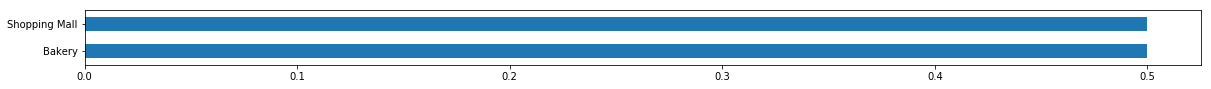

In [13]:
cluster_0.iloc[0,:][cluster_0.iloc[0,:]>0.01].plot(kind='barh', figsize=(20,1))

The foursquare API gives us the top 100 venues in the locality. We take the presence of an established shopping mall into consideration.

Cluster 1:

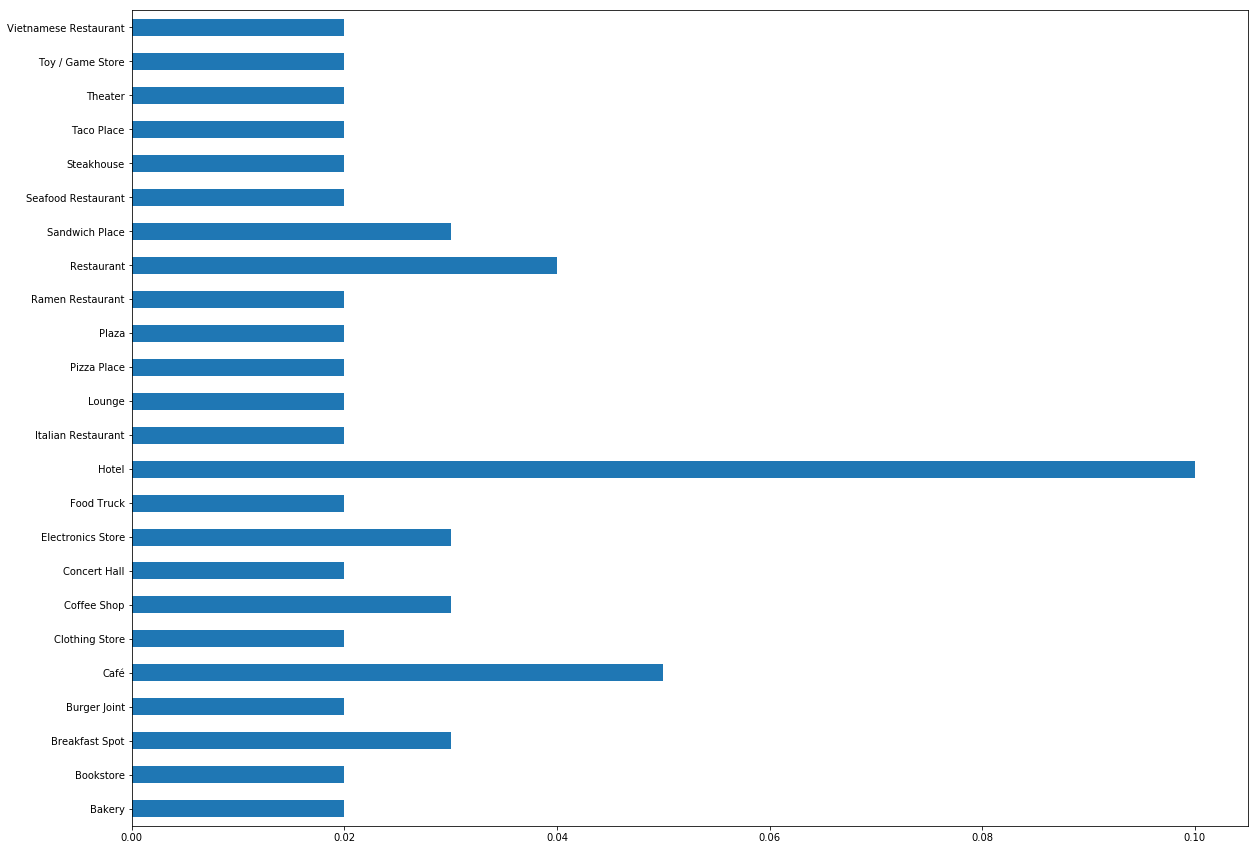

In [14]:
cluster_1.iloc[0,:][cluster_1.iloc[0,:]>0.01].plot(kind='barh', figsize=(20,15))

These seem to be well established localities with a lot of options where the barriers of entry might be high.

Cluster 2:

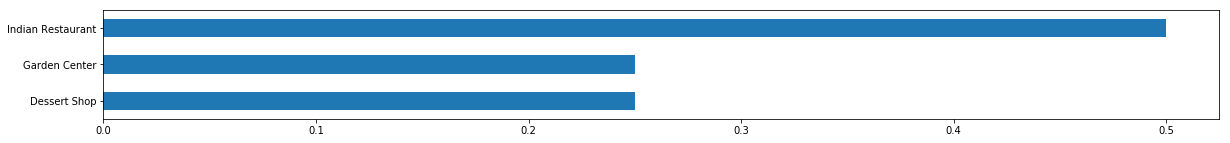

In [15]:
cluster_2.iloc[0,:][cluster_2.iloc[0,:]>0.01].plot(kind='barh', figsize=(20,2))

This cluster seems to be more residential with less barriers of entry.

Plotting these clusters:

In [16]:
map_clusters = folium.Map(location=[49.25, -123.1207], zoom_start=12)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for geom in vancouver[vancouver['Cluster']==0]['Geom']:
    folium.GeoJson(
    geom,
    style_function=lambda feature: {
        'fillColor': rainbow[0],
        'color' : rainbow[0],
        'weight' : 1,
        'fillOpacity' : 0.4,
        }).add_to(map_clusters)
for geom in vancouver[vancouver['Cluster']==1]['Geom']:
    folium.GeoJson(
    geom,
    style_function=lambda feature: {
        'fillColor': rainbow[1],
        'color' : rainbow[1],
        'weight' : 1,
        'fillOpacity' : 0.4,
        }).add_to(map_clusters)
for geom in vancouver[vancouver['Cluster']==2]['Geom']:
    folium.GeoJson(
    geom,
    style_function=lambda feature: {
        'fillColor': rainbow[2],
        'color' : rainbow[2],
        'weight' : 1,
        'fillOpacity' : 0.4,
        }).add_to(map_clusters)

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(vancouver['Latitude'], vancouver['Longitude'], vancouver['Name'], vancouver['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    color_map = rainbow[cluster]
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=color_map,
        fill_opacity=0.7).add_to(map_clusters)

    


<img src='https://github.com/Inder-Dhillon/Where-To-Open-Establishment/raw/master/files/Cluster.PNG' style="float: left;">

Localities in Cluster 1:

In [17]:
vancouver[vancouver['Cluster']==1]['Name']

1                     Downtown
2                     Fairview
3           Grandview-Woodland
4             Hastings-Sunrise
5                      Marpole
6                   Riley Park
7                  Shaughnessy
8                   Strathcona
9                     West End
10           Dunbar-Southlands
11                  Kerrisdale
12                   Killarney
13                   Kitsilano
14                South Cambie
15         Victoria-Fraserview
16    Kensington-Cedar Cottage
17              Mount Pleasant
18                    Oakridge
19         Renfrew-Collingwood
21             West Point Grey
Name: Name, dtype: object

A differentiation strategy must be applied in these localities if a pizza place is to be opened. A lot of investment will be required due to high barriers of entry and to provide differentiated value to attract customers.

Localities in Cluster 2:

In [18]:
vancouver[vancouver['Cluster']==2]['Name']

20    Sunset
Name: Name, dtype: object

Localities in this cluster are appropriate for small mom and pop stores which don't require a lot of investment and marketing. Stores here can remain profitable just off the basis of a lack of competition and having a market stronghold.

Localities in Cluster 3:

In [19]:
vancouver[vancouver['Cluster']==0]['Name']

0    Arbutus-Ridge
Name: Name, dtype: object

Opening a franchise pizza store (like Pizza Hut) is opt for this cluster due to the presense of a prominent shopping mall.